# Bitcoin Real-Time Analysis — Example Application
This notebook provides an end-to-end walkthrough of real-time Bitcoin price ingestion, processing, and visualization using `bitcoin_utils.py`.

##  Setup and Initialization

In [1]:
# Uncomment below if you're using Google Colab
!pip install ray pandas requests plotly

import ray
import time
import pandas as pd
import matplotlib.pyplot as plt

ray.shutdown()
ray.init(ignore_reinit_error=True, include_dashboard=False)


2025-05-17 23:35:58,891	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=1.68gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-05-17 23:36:00,038	INFO worker.py:1752 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.8.10', ray_version='2.10.0', ray_commit='09abba26b5bf2707639bb637c208d062a47b46f6')

## Import API Functions

In [2]:
from bitcoin_utils import fetch_bitcoin_price, PriceProcessor, fetch_hourly_btc_yfinance



2025-05-17 23:36:04,208	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=1.68gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-05-17 23:36:05,347	INFO worker.py:1752 -- Started a local Ray instance.


## Ingest Real-Time Bitcoin Data by using CoinGecko API

In [3]:
processor = PriceProcessor.remote()
for _ in range(10):  # Simulate real-time fetches
    ts, pr = ray.get(fetch_bitcoin_price.remote())
    ray.get(processor.add_price.remote(ts, pr))
    time.sleep(60)  # 1-minute intervals


## Prepare DataFrame

In [4]:
data = ray.get(processor.get_data_with_readable_time.remote())
df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()


timestamp   price
0 2025-05-17 23:36:06  103160
1 2025-05-17 23:37:07  103162
2 2025-05-17 23:38:08  103161
3 2025-05-17 23:39:08  103163
4 2025-05-17 23:40:08  103164

### Fetching  Historical Data from at present using YFinance


In [5]:
df_hist = fetch_hourly_btc_yfinance()
df_hist.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_hist.columns]
df_hist.reset_index(inplace=True)
df_hist.head()

Fetching BTC-USD data for the past 7d at 1m intervals...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


index                 Datetime_  Close_BTC-USD   High_BTC-USD  \
0      0 2025-05-11 00:01:00+00:00  104692.960938  104692.960938   
1      1 2025-05-11 00:02:00+00:00  104744.203125  104744.203125   
2      2 2025-05-11 00:03:00+00:00  104836.476562  104836.476562   
3      3 2025-05-11 00:04:00+00:00  104894.148438  104894.148438   
4      4 2025-05-11 00:05:00+00:00  104869.726562  104869.726562   

     Low_BTC-USD   Open_BTC-USD  Volume_BTC-USD  
0  104692.960938  104692.960938               0  
1  104744.203125  104744.203125        60903424  
2  104836.476562  104836.476562         8392704  
3  104894.148438  104894.148438       793272320  
4  104869.726562  104869.726562               0

### Removing TimeZone Information from Historical Timestamp, Trimming the Historical Dataset, Combining the Historical and Real Time Dataframes


In [6]:
# Remove timezone info from historical timestamp
df_hist["Datetime_"] = df_hist["Datetime_"].dt.tz_localize(None)

df_hist_trimmed = df_hist[["Datetime_", "Close_BTC-USD"]].rename(columns={"Datetime_": "timestamp","Close_BTC-USD": "price"})
df_hist_trimmed = df_hist_trimmed[["timestamp", "price"]]
print(df_hist_trimmed.head())

df["timestamp"] = pd.to_datetime(df["timestamp"])


df_combined = pd.concat([df_hist_trimmed, df], ignore_index=True)
df_combined.to_csv("bitcoin_7d_plus_realtime.csv", index=False)
print(" Cleaned and saved combined dataset with 2 columns: timestamp and price")
print(df_combined.head())
df_combined.tail()


            timestamp          price
0 2025-05-11 00:01:00  104692.960938
1 2025-05-11 00:02:00  104744.203125
2 2025-05-11 00:03:00  104836.476562
3 2025-05-11 00:04:00  104894.148438
4 2025-05-11 00:05:00  104869.726562
 Cleaned and saved combined dataset with 2 columns: timestamp and price
            timestamp          price
0 2025-05-11 00:01:00  104692.960938
1 2025-05-11 00:02:00  104744.203125
2 2025-05-11 00:03:00  104836.476562
3 2025-05-11 00:04:00  104894.148438
4 2025-05-11 00:05:00  104869.726562


timestamp     price
8849 2025-05-17 23:41:08  103172.0
8850 2025-05-17 23:42:08  103176.0
8851 2025-05-17 23:43:08  103182.0
8852 2025-05-17 23:44:08  103185.0
8853 2025-05-17 23:45:08  103187.0

##Exploratory Data Analysis

## DataSet Overview

In [7]:
# Time range
print("Start Date:", df_combined["timestamp"].min())
print("End Date:", df_combined["timestamp"].max())
df_combined.sort_values("timestamp",inplace=True)

Start Date: 2025-05-11 00:01:00
End Date: 2025-05-17 23:45:08


In [8]:
print("total records:",df_combined.shape)

total records: (8854, 2)


In [9]:
print('Statistics Summary of the Dataset:')
df_combined.describe()

Statistics Summary of the Dataset:


timestamp          price
count                           8854    8854.000000
mean   2025-05-14 14:05:29.344590080  103503.832333
min              2025-05-11 00:01:00  101023.757812
25%              2025-05-12 17:33:30  103057.648438
50%              2025-05-14 16:45:30  103603.308594
75%              2025-05-16 09:53:30  103989.341797
max              2025-05-17 23:45:08  105686.765625
std                              NaN     690.920907

## Bitcoin Prices Over Time Plot

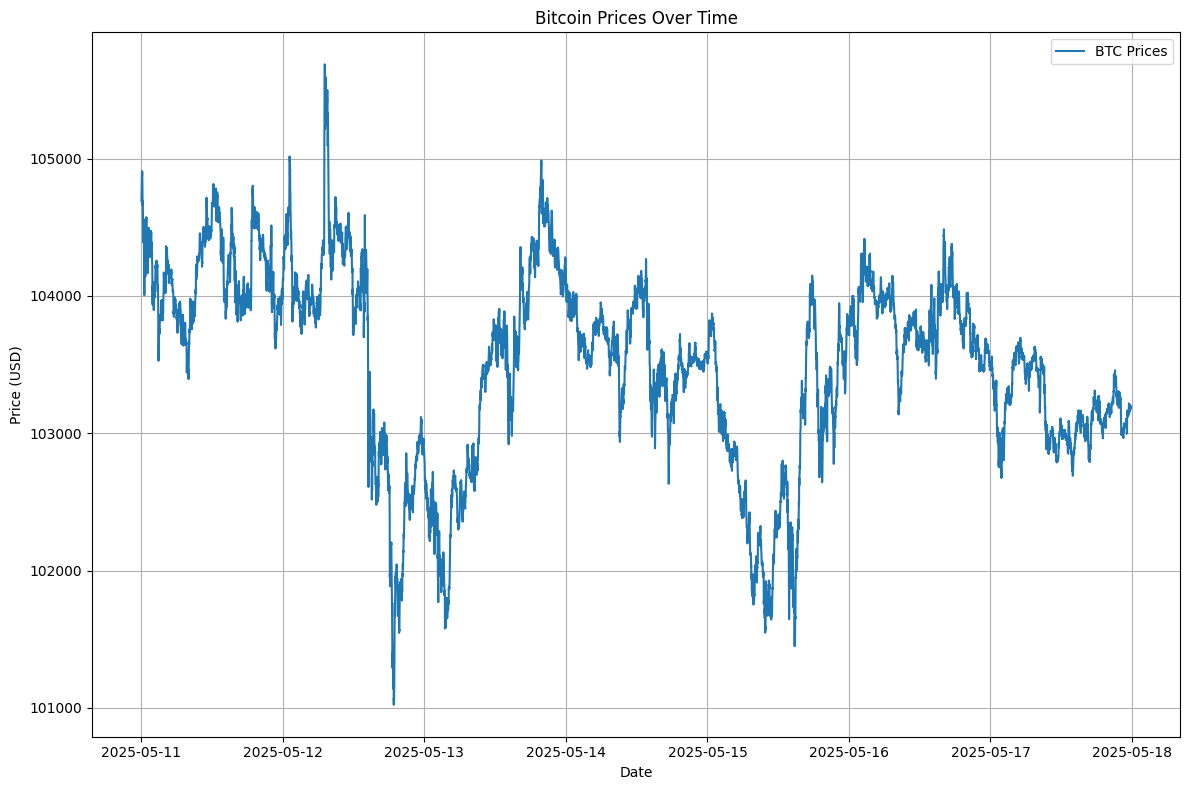

In [10]:
plt.figure(figsize=(12,8))
plt.plot(df_combined["timestamp"], df_combined["price"], label='BTC Prices')
plt.title('Bitcoin Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
print("The number of missing entries:")
df_combined.isnull().sum()

The number of missing entries:


timestamp    0
price        0
dtype: int64

## Understanding distribution of the data

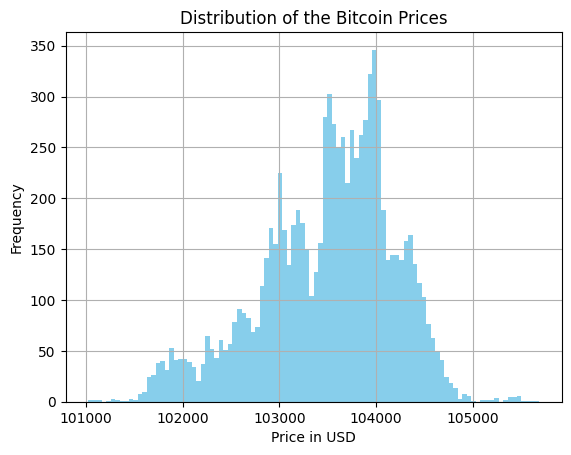

In [12]:
plt.hist(df_combined["price"],bins=100,color='skyblue')
plt.title('Distribution of the Bitcoin Prices')
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.grid(True)

The histogram reveals a unimodal distribution of Bitcoin prices, with the most frequent prices clustered between $103,500 and $104,000. This suggests a period of relative market stability, with prices oscillating around a narrow band. A slightly longer right tail indicates the presence of occasional upward spikes, hinting at transient bullish activity or market speculation.

## Calculating Percentage Changes

In [13]:
pct_changes = ray.get(processor.compute_percentage_changes.remote())
df_pct_changes = pd.DataFrame(pct_changes)
display(df_pct_changes.head())

timestamp   price  percent_change
0  2025-05-17 23:37:07  103162          0.0019
1  2025-05-17 23:38:08  103161         -0.0010
2  2025-05-17 23:39:08  103163          0.0019
3  2025-05-17 23:40:08  103164          0.0010
4  2025-05-17 23:41:08  103172          0.0078

## Filtering Values Based on Threshold

In [14]:
threshold = 40000
filtered_prices = ray.get(processor.filter_prices_above.remote(threshold))
df_filtered = pd.DataFrame(filtered_prices)
print(f"Prices above ${threshold}:")
display(df_filtered.head())

Prices above $40000:


timestamp   price
0  2025-05-17 23:36:06  103160
1  2025-05-17 23:37:07  103162
2  2025-05-17 23:38:08  103161
3  2025-05-17 23:39:08  103163
4  2025-05-17 23:40:08  103164

## Plot: Price + Moving Average Using MatplotLib

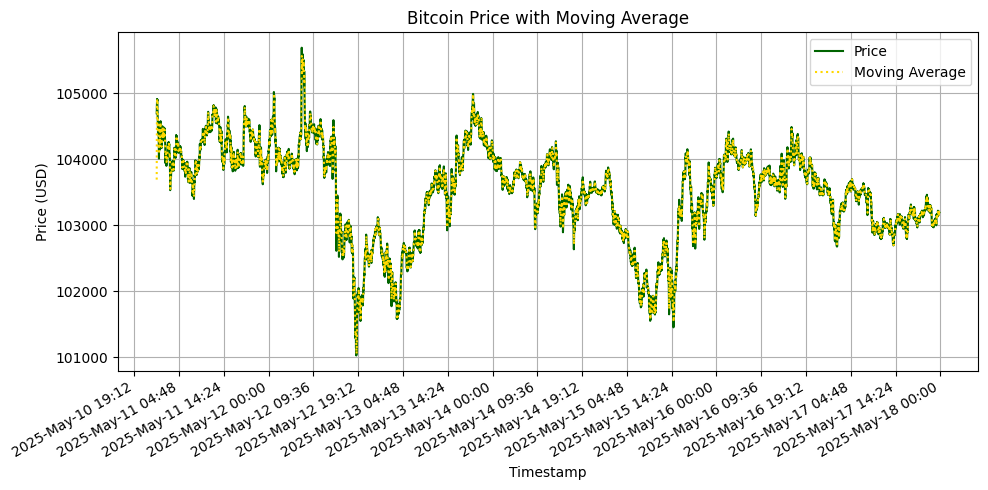

In [15]:
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

from bitcoin_utils import PriceProcessor, load_csv_to_actor


# Step 2: Load CSV at runtime and feed into actor
csv_file = "bitcoin_7d_plus_realtime.csv"  # Replace with your runtime file
load_csv_to_actor(csv_file, processor)

# Step 3: Compute moving average via the actor
window_size = 3
moving_avg_data = ray.get(processor.compute_moving_average.remote(window=window_size))
df_moving_avg = pd.DataFrame(moving_avg_data)
df_moving_avg["timestamp"] = pd.to_datetime(df_moving_avg["timestamp"], unit="s")

# *** Dropping Duplicates, and sorting te values of the timestamp
# *** Dropping NaNs in place on the df_moving_avg.
df_moving_avg.drop_duplicates(subset="timestamp", inplace=True)
df_moving_avg.sort_values("timestamp", inplace=True)
df_moving_avg.dropna(subset=["price", "moving_avg"], inplace=True)

# Step 4: Plot
plt.figure(figsize=(10, 5))

plt.plot(
    df_moving_avg["timestamp"],
    df_moving_avg["price"],
    label="Price",
    color="darkgreen",
    linestyle='-'
)

plt.plot(
    df_moving_avg["timestamp"],
    df_moving_avg["moving_avg"],
    label="Moving Average",
    color="gold",
    linestyle=':'
)

plt.xlabel("Timestamp")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price with Moving Average")
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b-%d %H:%M'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.savefig("price_moving_avg_runtime.png")
plt.show()

## Plot: Price + Moving Average Using Plotly

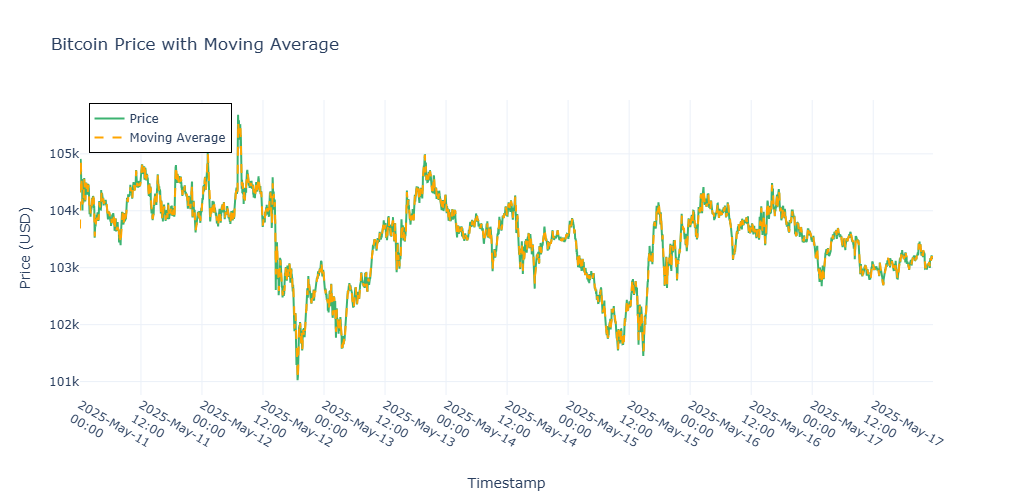

In [16]:
import plotly.graph_objects as go

# Step 5: Plot using Plotly
fig = go.Figure()

# Price trace
fig.add_trace(go.Scatter(
    x=df_moving_avg["timestamp"],
    y=df_moving_avg["price"],
    mode='lines',
    name='Price',
    line=dict(color='mediumseagreen', width=2)
))

# Moving Average trace
fig.add_trace(go.Scatter(
    x=df_moving_avg["timestamp"],
    y=df_moving_avg["moving_avg"],
    mode='lines',
    name='Moving Average',
    line=dict(color='orange', width=2, dash='dash')  # Dashed red for visibility
))

# Layout and formatting
fig.update_layout(
    title='Bitcoin Price with Moving Average',
    xaxis_title='Timestamp',
    yaxis_title='Price (USD)',
    xaxis=dict(
        showgrid=True,
        tickformat='%Y-%b-%d<br>%H:%M',
        nticks=20
    ),
    yaxis=dict(showgrid=True),
    legend=dict(x=0.01, y=0.99, bordercolor="Black", borderwidth=1),
    hovermode='x unified',
    height=500,
    width=1000,
    template='plotly_white'
)

# Show interactive plot
fig.show()


## Plot: Volatility using Matplotlib

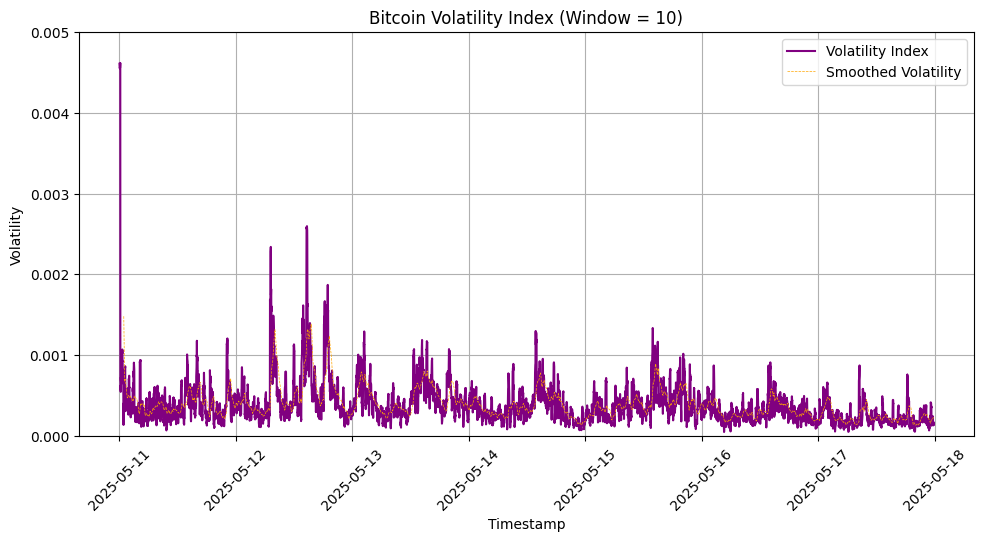

In [17]:

volatility_data = ray.get(processor.compute_volatility.remote(window=10))

# Convert to DataFrame
df_volatility = pd.DataFrame(volatility_data)
df_volatility["timestamp"] = pd.to_datetime(df_volatility["timestamp"])
df_volatility.sort_values("timestamp", inplace=True)

df_volatility["volatility_smooth"] = df_volatility["volatility"].rolling(window=50).mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(
    df_volatility["timestamp"],
    df_volatility["volatility"],
    label="Volatility Index",
    color="purple",
    linestyle="-",
    linewidth=1.5
)

plt.plot(
    df_volatility["timestamp"],
    df_volatility["volatility_smooth"],
    label="Smoothed Volatility",
    color="orange",
    linestyle="--",
    linewidth=0.5
)

plt.xlabel("Timestamp")
plt.ylabel("Volatility")
plt.title("Bitcoin Volatility Index (Window = 10)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.ylim(0, 0.005)
plt.show()


## Plot: Volatility using Plotly

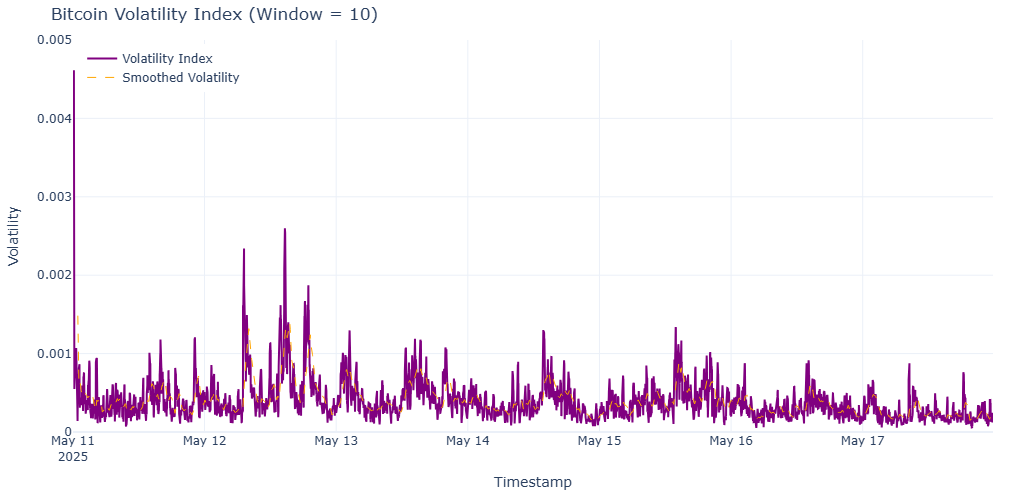

In [18]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add raw volatility trace
fig.add_trace(go.Scatter(
    x=df_volatility["timestamp"],
    y=df_volatility["volatility"],
    mode='lines',
    name='Volatility Index',
    line=dict(color='purple', width=2)
))

# Add smoothed volatility trace
fig.add_trace(go.Scatter(
    x=df_volatility["timestamp"],
    y=df_volatility["volatility_smooth"],
    mode='lines',
    name='Smoothed Volatility',
    line=dict(color='orange', width=1, dash='dash')
))

# Customize layout
fig.update_layout(
    title="Bitcoin Volatility Index (Window = 10)",
    xaxis_title="Timestamp",
    yaxis_title="Volatility",
    yaxis=dict(range=[0, 0.005]),
    template="plotly_white",
    legend=dict(x=0.01, y=0.99),
    margin=dict(l=40, r=20, t=40, b=40),
    height=500,
    hovermode='x unified'
)

fig.show()


## Deploying a Model

### Loading Necessary Libraries

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


#Normalizing Prices
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df_combined["price"].values.reshape(-1, 1))


2025-05-17 23:46:23.142964: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 23:46:23.193285: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 23:46:23.194708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-17 23:46:23.976916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
# Preparing sequences for LSTM
window_size = 10
X, y = [], []
for i in range(window_size, len(scaled_prices)):
    X.append(scaled_prices[i - window_size:i, 0])
    y.append(scaled_prices[i, 0])
X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [21]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


## Building LSTM Model

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compiling & Training
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
222/222 [==============================] - 4s 8ms/step - loss: 0.0093
Epoch 2/20
222/222 [==============================] - 2s 8ms/step - loss: 0.0028
Epoch 3/20
222/222 [==============================] - 2s 8ms/step - loss: 0.0025
Epoch 4/20
222/222 [==============================] - 2s 8ms/step - loss: 0.0024
Epoch 5/20
222/222 [==============================] - 2s 8ms/step - loss: 0.0022
Epoch 6/20
222/222 [==============================] - 2s 9ms/step - loss: 0.0020
Epoch 7/20
222/222 [==============================] - 2s 9ms/step - loss: 0.0018
Epoch 8/20
222/222 [==============================] - 2s 9ms/step - loss: 0.0017
Epoch 9/20
222/222 [==============================] - 2s 9ms/step - loss: 0.0015
Epoch 10/20
222/222 [==============================] - 2s 8ms/step - loss: 0.0015
Epoch 11/20
222/222 [==============================] - 2s 8ms/step - loss: 0.0012
Epoch 12/20
222/222 [==============================] - 2s 9ms/step - loss: 0.0012
Epoch 13/20
222/222 [====

In [23]:
#Predicting
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluating
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
accuracy = 100 - mape

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, Accuracy: {accuracy:.2f}%")

56/56 [==============================] - 1s 4ms/step
MAE: 29.00, RMSE: 40.58, MAPE: 0.03%, Accuracy: 99.97%


## Plotting Actual Vs Predicted using Matplotlib

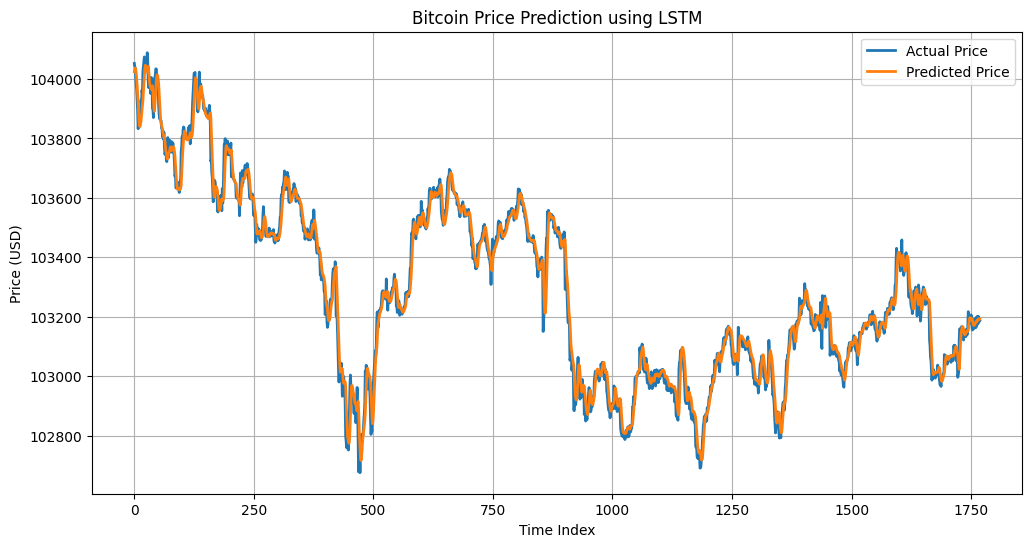

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', linewidth=2)
plt.plot(y_pred, label='Predicted Price', linewidth=2)
plt.title("Bitcoin Price Prediction using LSTM")
plt.xlabel("Time Index")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

## Plotting Actual Vs Predicted using Plotly

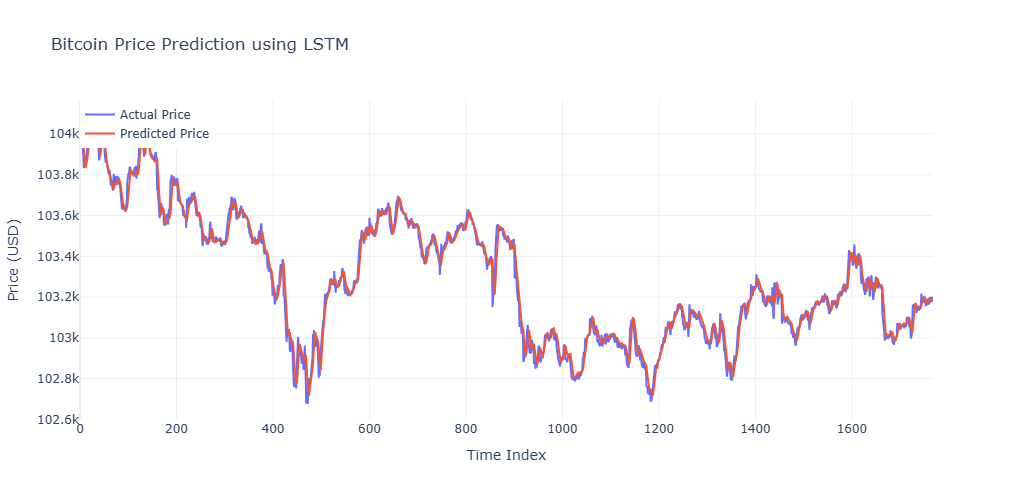

In [25]:
import plotly.graph_objects as go
import numpy as np

# Use same x-axis values
x = np.arange(len(y_test_actual))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x,
    y=y_test_actual.flatten(),
    mode='lines',
    name='Actual Price',
    line=dict(width=2)
))

fig.add_trace(go.Scatter(
    x=x,
    y=y_pred.flatten(),
    mode='lines',
    name='Predicted Price',
    line=dict(width=2)
))

fig.update_layout(
    title="Bitcoin Price Prediction using LSTM",
    xaxis_title="Time Index",
    yaxis_title="Price (USD)",
    legend=dict(x=0, y=1),
    template="plotly_white",
    height=500,
    width=900,
    hovermode='x unified'
)

fig.show()
